In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from model import GraphNet
from utils import get_device, DotDict, load_checkpoint, BeamSearch

# noinspection PyUnresolvedReferences
from utils.data import (
    load_and_split_dataset,
    process_datasets,
    adj_matrix_from_routes,
    distance_from_adj_matrix,
)

sns.set_theme()

In [ ]:
device = get_device()
print("Device", device)

In [49]:
from joblib import Parallel, delayed


def is_tour_over_capacity(tour, demand):
    loads = np.take(demand, tour)
    running_load = 0

    for j in range(len(loads)):
        running_load += loads[j]

        if tour[j] == 0 or j == len(loads) - 1:
            if np.round(running_load, 2) > 1.0:
                return True
            running_load = 0

    return False


def _check_valid(tour, demand, num_nodes):
    count = np.bincount(tour, minlength=num_nodes)

    over_capacity = is_tour_over_capacity(tour, demand)
    all_nodes_visited = np.all(count[1:] == 1)

    return all_nodes_visited and not over_capacity


def check_valid_tours(tours, demands, num_nodes):
    assert (
        tours.shape[0] == demands.shape[0]
    ), "Batch size of tours and demands must match"
    assert isinstance(tours, np.ndarray) and isinstance(
        demands, np.ndarray
    ), "tours and demands must be numpy arrays"

    valid_tours = np.ones(tours.shape[0], dtype=bool)

    for i, tour in enumerate(tours):
        valid_tours[i] = _check_valid(tour, demands[i], num_nodes)

    return valid_tours


def beam_search(y_preds, batch_node_features, num_vehicles, beam_width=1280):
    y_preds = y_preds.cpu()
    batch_demands = (
        batch_node_features[..., 2].cpu() if batch_node_features is not None else None
    )

    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(
        y_preds,
        demands=batch_demands,
        beam_width=beam_width,
        num_vehicles=num_vehicles,
    )
    beamsearch.search()

    return beamsearch


def get_tour_length_and_validity(
    current_tour, batch_dist_matrix, batch_demands, num_nodes
):
    tour_length = distance_from_adj_matrix(
        adj_matrix_from_routes(current_tour, num_nodes), batch_dist_matrix
    )
    valid_tour = check_valid_tours(current_tour, batch_demands, num_nodes)

    return current_tour, tour_length, valid_tour


def shortest_tour(
    y_preds, batch_dist_matrix, batch_node_features, num_vehicles, beam_width=1280
):
    bs = beam_search(y_preds, batch_node_features, num_vehicles, beam_width)

    batch_dist_matrix = batch_dist_matrix.cpu().numpy()
    batch_demands = batch_node_features[..., 2].cpu().numpy()

    shortest_tour = np.zeros((bs.batch_size, len(bs.next_nodes)), dtype=int)
    shortest_tour_length = np.full((bs.batch_size,), np.inf)

    results = Parallel(n_jobs=-1)(
        delayed(get_tour_length_and_validity)(
            bs.get_beam(i).numpy(), batch_dist_matrix, batch_demands, bs.num_nodes
        )
        for i in range(bs.beam_width)
    )

    for current_tour, tour_length, valid_tour in results:
        for i in range(bs.batch_size):
            if valid_tour[i] and tour_length[i] < shortest_tour_length[i]:
                shortest_tour[i] = current_tour[i]
                shortest_tour_length[i] = tour_length[i]

    return shortest_tour, shortest_tour_length


def most_probable_tour(
    y_preds, batch_dist_matrix, batch_node_features, num_vehicles, beam_width=1280
):
    bs = beam_search(y_preds, batch_node_features, num_vehicles, beam_width)

    # get most probable tours (index = 0)
    tours = bs.get_beam(0)

    tours = tours.cpu().numpy()
    batch_dist_matrix = batch_dist_matrix.cpu().numpy()

    tour_lengths = distance_from_adj_matrix(
        adj_matrix_from_routes(tours, batch_dist_matrix.shape[-1]), batch_dist_matrix
    )

    return tours, tour_lengths


def eval_model(batch_node_features, batch_dist_matrix, batch_edge_features, model):
    model.eval()

    with torch.no_grad():
        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
        preds = F.softmax(preds, dim=3)

        return preds

In [56]:
# MODEL_PATH = Path("runs/exp_PCA_lr_0.01_decay_105")
MODEL_PATH = Path("runs/exp_PCA_dim_100_layer_20_decay")
# MODEL_PATH = Path("runs/exp_baseline_PCA")

checkpoint = load_checkpoint(MODEL_PATH / "last_epoch_model.pt")
config = DotDict(checkpoint["config"])

In [57]:
from collections import OrderedDict


def rename_old_keys(checkpoint):
    new_state_dict = OrderedDict()

    for old_key in checkpoint["model_state_dict"].keys():
        if old_key.startswith("mlp_edges"):
            parts = old_key.split(".")[1:]
            new_key = ".".join(["mlp"] + parts)

            new_state_dict[new_key] = checkpoint["model_state_dict"][old_key]
        else:
            new_state_dict[old_key] = checkpoint["model_state_dict"][old_key]

    return new_state_dict


checkpoint["model_state_dict"] = rename_old_keys(checkpoint)

In [58]:
model = GraphNet(config).to(device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [59]:
train_dataset, test_dataset = process_datasets(
    load_and_split_dataset("data/vrp_20_3s.pkl", test_size=0.05), k=6
)

print(len(train_dataset), len(test_dataset))

19000 1000


In [60]:
test_dataloader = DataLoader(
    test_dataset, batch_size=config.test_batch_size, shuffle=True
)
batch_features, batch_targets = next(iter(test_dataloader))
rand_choices = np.random.choice(len(batch_targets), 10)

In [61]:
batch_node_features = batch_features["node_features"].to(device)
batch_dist_matrix = batch_features["dist_matrix"].to(device)
batch_edge_features = batch_features["edge_feat_matrix"].to(device)
batch_targets = batch_targets.to(device)

preds = eval_model(
    batch_node_features, batch_dist_matrix, batch_edge_features, model=model
)

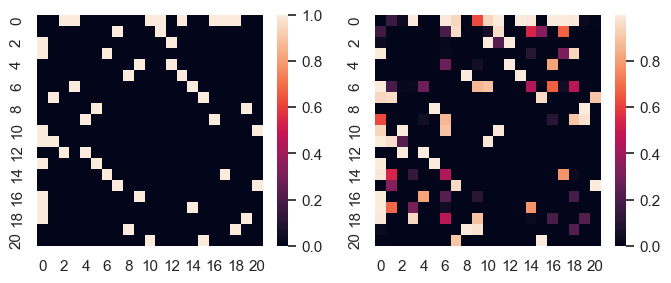

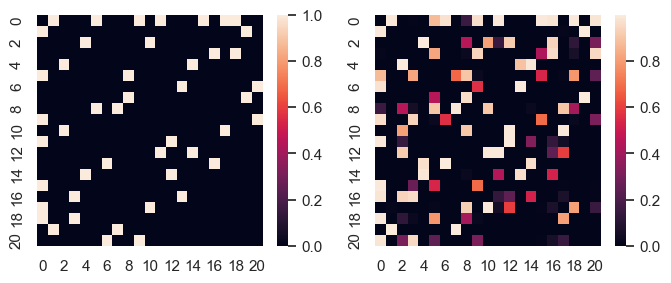

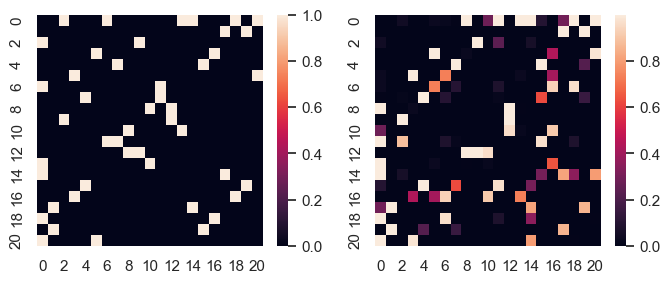

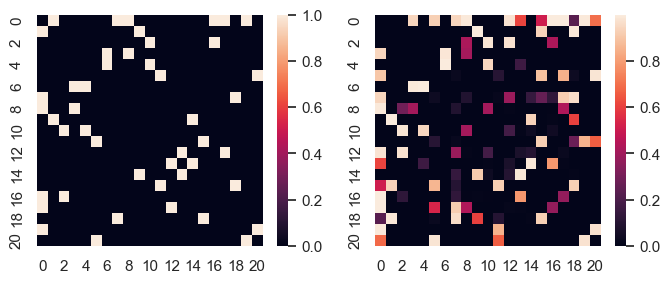

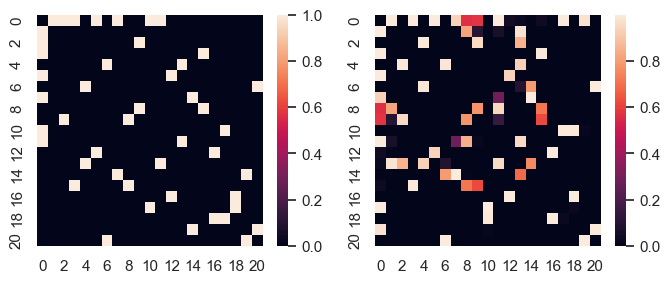

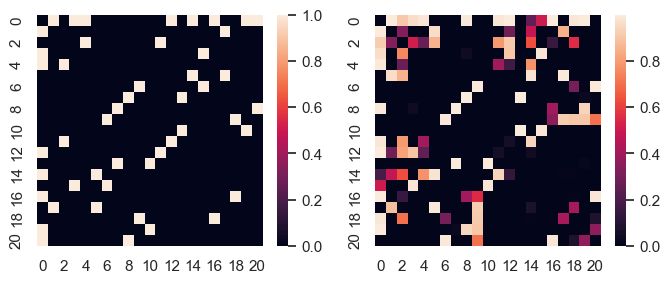

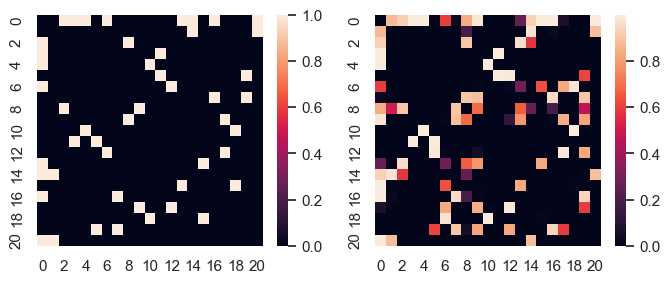

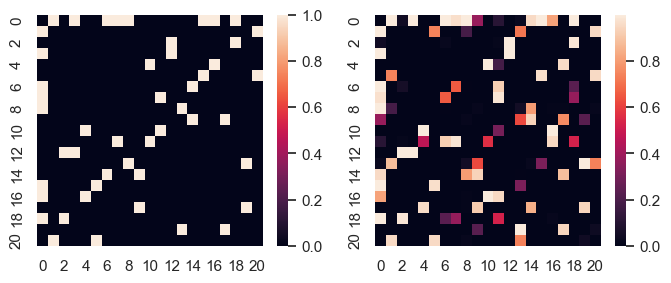

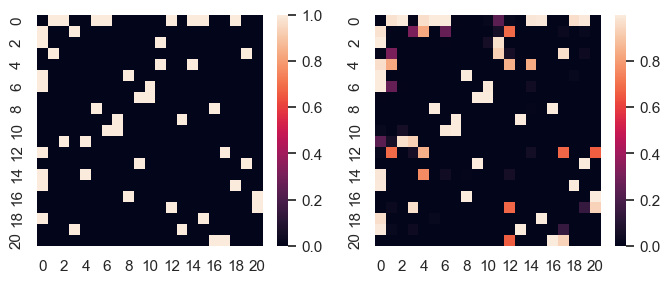

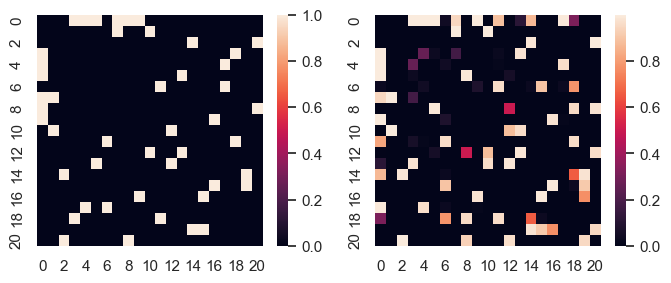

In [62]:
for choice in rand_choices:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sns.heatmap(batch_targets[choice].cpu().numpy(), ax=ax[0])
    sns.heatmap(preds[choice, ..., 1].cpu().numpy(), ax=ax[1])

    plt.show()

In [ ]:
from utils.plot import plot_graph, plot_heatmap, plot_beam_search_tour

actual_distance = distance_from_adj_matrix(batch_targets, batch_dist_matrix)
greedy_routes, greedy_distances = most_probable_tour(
    preds, batch_dist_matrix, batch_node_features, num_vehicles=5, beam_width=10
)
routes, distances = shortest_tour(
    preds, batch_dist_matrix, batch_node_features, num_vehicles=5, beam_width=1280
)

actual_distance = actual_distance.cpu().numpy()
node_features = batch_node_features.cpu().numpy()
targets = batch_targets.cpu().numpy()
predictions = preds[..., 1].cpu().numpy()

for i in rand_choices:
    print(f"Sample: {i}")
    print(f"Route: {routes[i]}")
    fig, ax = plt.subplots(1, 4, figsize=(8, 3))

    plot_graph(node_features[i, :, :2], targets[i], ax=ax[0])
    plot_heatmap(node_features[i, :, :2], targets[i], predictions[i], ax=ax[1])
    plot_beam_search_tour(node_features[i, :, :2], targets[i], routes[i], ax=ax[2])
    plot_beam_search_tour(
        node_features[i, :, :2], targets[i], greedy_routes[i], ax=ax[3]
    )

    ax[0].set_title(f"Ground truth ({actual_distance[i]:.2f})")
    ax[1].set_title("Predictions")
    ax[2].set_title(f"Shortest tour ({distances[i]:.2f})")
    ax[3].set_title(f"Greedy tour ({greedy_distances[i]:.2f})")
    fig.tight_layout()

    plt.show()

# Performance

In [63]:
test_dataloader = DataLoader(
    test_dataset, batch_size=config.test_batch_size, shuffle=True
)

In [69]:
distances = []

for batch_features, batch_targets in test_dataloader:
    batch_node_features = batch_features["node_features"].to(device)
    batch_dist_matrix = batch_features["dist_matrix"].to(device)
    batch_edge_features = batch_features["edge_feat_matrix"].to(device)
    batch_targets = batch_targets.to(device)

    preds = eval_model(
        batch_node_features, batch_dist_matrix, batch_edge_features, model=model
    )

    actual_distance = (
        distance_from_adj_matrix(batch_targets, batch_dist_matrix).cpu().numpy()
    )

    _greedy_routes, greedy_distances = most_probable_tour(
        preds, batch_dist_matrix, batch_node_features, num_vehicles=5, beam_width=1
    )
    _routes, shortest_distances = shortest_tour(
        preds, batch_dist_matrix, batch_node_features, num_vehicles=5, beam_width=1280
    )

    distances.append((actual_distance, greedy_distances, shortest_distances))

In [70]:
actual_distances, greedy_distances, shortest_distances = zip(*distances)

In [71]:
actual_distances = np.concatenate(actual_distances)
greedy_distances = np.concatenate(greedy_distances)
shortest_distances = np.concatenate(shortest_distances)

In [72]:
actual_distances.mean(), greedy_distances.mean(), shortest_distances.mean(
    where=~np.isinf(shortest_distances)
)

(6.151031, 7.686018954324303, 6.765936468933961)

In [68]:
np.isinf(actual_distances).sum(), np.isinf(greedy_distances).sum(), np.isinf(
    shortest_distances
).sum()

(0, 0, 6)

(6.1510305, 7.1438315849878125, 6.6899047254479065)

(6.1510305, 7.241711750709684, 6.753498771553133)